In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
% matplotlib inline


extract_features_flag = 0
split_data_flag = 0
train_model_flag = 0


## Load Filenames

In [5]:
if extract_features_flag == 1:
    cars = []
    notcars = []
    notcars = glob.iglob('data/non-vehicles/**/*.png', recursive=True)

    cars = glob.iglob('data/vehicles/**/*.png', recursive=True)

In [6]:
if extract_features_flag == 1:
    ## Parameters
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [500, 650] # Min and max in y to search in slide_window()

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Save the scalers!!
    pickle.dump(X_scaler, open('X_scaler.p','wb'))
    # Save features
    pickle.dump(scaled_X, open('scaled_X.p','wb'))

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Save features
    pickle.dump(y, open('y.p','wb'))


In [7]:
# Opposite of above
if extract_features_flag == 0:
    X_scaler = pickle.load(open('X_scaler.p','rb'))
    scaled_X = pickle.load(open('scaled_X.p','rb'))
    y = pickle.load(open('y.p','rb'))


## Split into train and test


In [8]:
if split_data_flag ==1:
    # Split up data into randomized training and test sets
    rand_state = 5757 #np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                        test_size=0.2, 
                                                        random_state=rand_state, 
                                                        shuffle=True)

    # Save train and test data
    trainTest = [X_train, X_test, y_train, y_test ]
    pickle.dump(trainTest, open('train_test_splits.p','wb'))
    
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

## Train a Model

In [9]:
################################################################
## TRAIN A MODEL
################################################################
if train_model_flag == 1:
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()

    pickle.dump(svc, open('svc_model.p','wb'))

## Search and Predict on New Image

/Users/andrew/miniconda2/envs/keras2/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


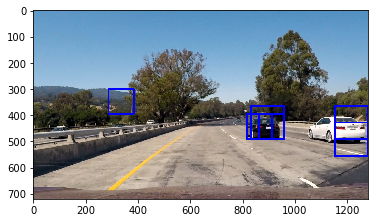

In [2]:
# load model
svc = pickle.load(open('svc_model.p','rb'))
X_scaler = pickle.load(open('X_scaler.p','rb'))

# Load Image
image = mpimg.imread('test_image.jpg')
draw_image = np.copy(image)

# Params
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, 650] # Min and max in y to search in slide_window()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

y_start_stop = [300, 650]

window_size_list = [(96, 96), (128, 128)]
windows = []

for ws in window_size_list:
    # Slide window
    wd = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=ws, xy_overlap=(0.5, 0.5))
    # Concatenate window list
    windows = windows + wd

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
                   
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

## Filter out false positives and duplicates

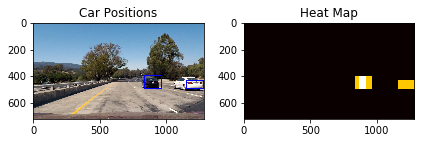

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))
box_list = hot_windows

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

## One Function Detection for video (combines above funcs)

In [13]:
def pipeline(image):
    # Uncomment if training in on png and classification on jpg
    # Comment for Video
    global car
    draw_image = np.copy(image)  
    image = image.astype(np.float32)/255
    
    everyNFrames = 3
    # process every second frame
    if car.getCounterMod(everyNFrames) == 0:


        y_start_stop = [300, 650]

        window_size_list = [(96, 96), (128, 128)]
        windows = []

        for ws in window_size_list:
            # Slide window
            wd = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                xy_window=ws, xy_overlap=(0.5, 0.5))
            # Concatenate window list
            windows = windows + wd

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)   

        #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

        # Create empty heat map
        heat = np.zeros_like(image[:,:,0]).astype(np.float)


        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Reset Heatmap every 3 iterations
#         if car.cnt % (everyNFrames*3) == 0:
#             car.setHeatmap(np.zeros_like(image[:,:,0]).astype(np.float))
            
            
        ## Do some smoothing if not on first frame
#         if car.cnt > 0:
#             smoothing = 0.999
#             heatmap = cv2.addWeighted(heatmap, smoothing, car.getHeatmap(), (1-smoothing),0)
#             #heatmap = (heatmap*smoothing + car.getHeatmap()*(1-smoothing) ) / 2
        
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
    
         # Save the labels for next time
        car.setLabels(labels)
        car.setHeatmap(heatmap)
        
    else:
        # We will use the boxes from the last frame
        labels = car.getLabels()
        # We will use the heatmap from the last frame
        heatmap = car.getHeatmap()
        
    # Draw the boxes
    draw_img = draw_labeled_bboxes(draw_image, labels)

    # update frame counter
    car.updateCounter()
    
    return draw_img #, heatmap  


## RUN PIPELINE
# Params
# color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (32, 32) # Spatial binning dimensions
# hist_bins = 32    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [500, 650] # Min and max in y to search in slide_window()

# # Load Image
# fnames = glob.iglob('test_images/*.jpg', recursive=True)

# for filestr in fnames:
#     image = mpimg.imread(filestr)  
#     #draw_img = pipeline(image)
#     draw_img, heatmap = pipeline(image)

#     fig = plt.figure()
#     plt.subplot(121)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')

#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     fig.tight_layout()

#     plt.show()

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# load model
svc = pickle.load(open('svc_model.p','rb'))

output = 'project_video_output10.mp4'
## UNCOMMENT
# A short subclip
clip1 = VideoFileClip("project_video.mp4").subclip(10,17)
# clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output10.mp4
[MoviePy] Writing video project_video_output10.mp4


 99%|█████████▉| 175/176 [01:48<00:00,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output10.mp4 

CPU times: user 6min 27s, sys: 19.7 s, total: 6min 46s
Wall time: 1min 49s


# Method Used for Video

# Faster! New Hog Subsample Method

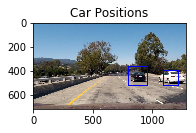

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    global car
    draw_img = np.copy(img)
    
    # process every second frame
    if car.getCounterMod(2) == 0:
    
        ## UNCOMMENT FOR PNG 
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        hot_windows = []

        # Iterate through Image Sub Windows
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Draw Hot windows on Image (there will be dups and false positives)
                    # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    # Append the hot windows
                    hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

        ##############################
        ## Deal with Dups
        ##############################
        # Create empty heat map
        heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        ## Do some smoothing if not on first frame
#         if car.cnt > 0:
#             smoothing = 0.999
#             heatmap = cv2.addWeighted(heatmap, smoothing, car.getHeatmap(), (1-smoothing),0)
#             #heatmap = (heatmap*smoothing + car.getHeatmap()*(1-smoothing) ) / 2
            
        # Find final boxes from heatmap using label function
        labels = label(heatmap)

        # Save the labels for next time
        car.setLabels(labels)
        car.setHeatmap(heatmap)

    else:
        # We will use the boxes from the last frame
        labels = car.getLabels()
        # We will use the heatmap from the last frame
        heatmap = car.getHeatmap()
        
    # draw the boxes
    draw_img = draw_labeled_bboxes(draw_img, labels)

    # update frame counter
    car.updateCounter()
    
    return draw_img, heatmap

def fastPipeline(img):
    
    ystart = 300
    ystop = 650
    scale = 1.5

    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins

    # HEATMAP
    out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    return out_img


########################################
## RUN FAST PIPELINE
########################################
# load model
svc = pickle.load(open('svc_model.p','rb'))
X_scaler = pickle.load(open('X_scaler.p','rb'))
car = carDetector()

# Read Image
img = mpimg.imread('test_image.jpg')

draw_img = fastPipeline(img)
# draw_img, heatmap = fastPipeline(img)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
# plt.subplot(122)
# plt.imshow(heatmap, cmap='hot')
# plt.title('Heat Map')
# fig.tight_layout()
plt.show()

# Final Output

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# load model
svc = pickle.load(open('svc_model.p','rb'))
X_scaler = pickle.load(open('X_scaler.p','rb'))
car = carDetector()

output = 'project_video_output13.mp4'
## UNCOMMENT
# A short subclip
# clip1 = VideoFileClip("project_video.mp4").subclip(35,40)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(fastPipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output12.mp4
[MoviePy] Writing video project_video_output12.mp4


100%|█████████▉| 1260/1261 [04:57<00:00,  4.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output12.mp4 

CPU times: user 15min 3s, sys: 1min 9s, total: 16min 13s
Wall time: 4min 58s
